# Lotka-Volterra Emulation and GSA

The Lotka-Volterra equations comprise a pair of first order, nonlinear, coupled, time-dependent ODEs
$$ \frac{dx}{dt} = \alpha x - \beta xy $$
$$ \frac{dy}{dt} = \delta xy - \gamma y $$
$$x(0)=a$$
$$y(0)=b$$
$$t\in [0,T]$$

$x$ is the prey population density

$y$ is the predator population density

$\alpha$ desribes maximum prey per capita growth rate

$\beta$ predator effect on prey growth rate

$\delta$ prey effect on predator growth rate

$\gamma$ predator per capita death rate


In [1]:
# Use ODEINT to solve the differential equations defined by the vector field
from scipy.integrate import odeint
import numpy as np

In [2]:
def lotkavolteraODE(w, t, p):
    """
    Defines the differential equations for the coupled Lotka-Volterra System
    Arguments:
        w :  vector of the state variables:
                  w = [x,y] 
        t :  time
        p :  vector of the parameters:
                  p = [alpha,beta,delta,gamma]
    """
    x, y = w
    alpha, beta,delta,gamma = p

    # Create f = (x',y'):
    f = [alpha*x-beta*x*y,
         delta*x*y-gamma*y]
    return f

In [3]:
def lotkaVolterra(w,t,p,SolveP):
    
    """
    Solves the lotkavolterraODE problem:
        w :  vector of the state variables:
                  w = [x,y] 
        t :  time
        p :  vector of the parameters:
                  p = [alpha,beta,delta,gamma]
        SolveP: vector of ODE solver parameters
                SolveP=[absolute error, relative error, end time, number of points in the mesh]
    """
    
    # Assign ODE solver parameters
    abserr = SolveP[0]
    relerr = SolveP[1]
    stoptime = SolveP[2]
    numpoints = SolveP[3]
    
    # Establish mesh
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
    
    # Solve coupled ODE problem
    wsol = odeint(lotkavolteraODE, w, t, args=(p,),
              atol=abserr, rtol=relerr)

    # combine time step and solution into single array
    output=np.hstack((np.array(t)[:,None],wsol)).T
    return output

## Set up system for example simulation

In [4]:
# ODE system parameters

alpha=1.1
beta=1.4
delta=0.5
gamma=0.4

# Initial conditions

x = 12
y = 1



# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 100.0
numpoints = 2500

# Create the time samples for the output of the ODE solver.
# I use a large number of points, only because I want to make
# a plot of the solution that looks nice.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

# Pack up the parameters and initial conditions:
p = [alpha,beta,delta,gamma]
w = [x, y]
SolveP=[abserr,relerr,stoptime ,numpoints]

# Output quantities

We define our quantities of interest as the maximum predator and prey population sizes over the interval.

Our unknown parameters will be $\alpha, \beta, \delta, \gamma$, the initial conditions $x(0)=a$ and $y(0)=b$. 

In [5]:
def maxPrey(w,t,p,SolveP):
    out = lotkaVolterra(w,t,p,SolveP)
    t, x1, x2 = out
    maxP = max(x1)
    return maxP

In [6]:
def maxPred(w,t,p,SolveP):
    out = lotkaVolterra(w,t,p,SolveP)
    t, x1, x2 = out
    maxP = max(x2)
    return maxP

In [7]:
def maxDensities(w,t,p,SolveP):
    out = lotkaVolterra(w,t,p,SolveP)
    t, x1, x2 = out
    preyMax = max(x1)
    predMax = max(x2)
    return preyMax, predMax

In [8]:
data=lotkaVolterra(w,t,p,SolveP)

In [9]:
maxPrey(w,t,p,SolveP)

12.071455943971062

In [10]:
maxPred(w,t,p,SolveP)

5.57635390997989

In [11]:
maxDensities(w,t,p,SolveP)

(12.071455943971062, 5.57635390997989)

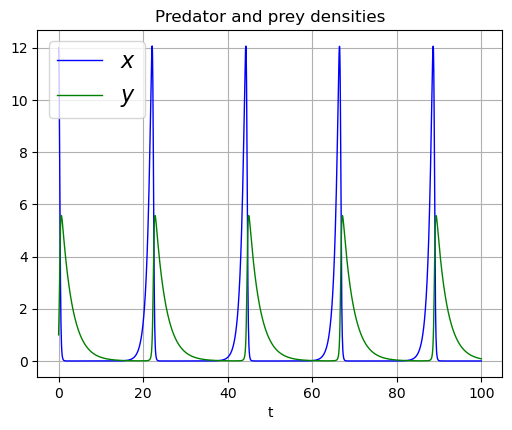

In [12]:
# Plot the solution of the entire system

from numpy import loadtxt
from pylab import figure, plot, xlabel, grid, legend, title, savefig
from matplotlib.font_manager import FontProperties

t, x1, x2 = data

figure(1, figsize=(6, 4.5))

xlabel('t')
grid(True)

lw = 1

plot(t, x1, 'b', linewidth=lw)
plot(t, x2, 'g', linewidth=lw)

legend((r'$x$', r'$y$'), prop=FontProperties(size=16))
title('Predator and prey densities')
savefig('two_springs.png', dpi=100)

In [13]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': 6,
    'names': ['alpha', 'beta', 'delta', 'gamma','a','b'],
    'bounds': [[1, 5],
               [1, 5],
               [1, 5],
               [1, 5],
               [0.1,5],
               [0.1,5]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

Yprey = np.zeros([param_values.shape[0]])
Ypred = np.zeros([param_values.shape[0]])
# Run model (example)
for i,p1 in enumerate(param_values):
    p=p1[0:4]
    w=[p1[4],p1[5]]
    preyMax,predMax= maxDensities(w,t,p,SolveP)
    Yprey[i] = preyMax
    Ypred[i] = predMax
    # Perform analysis

C:\Users\chris\AppData\Local\Temp\ipykernel_33148\3046155885.py:20: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


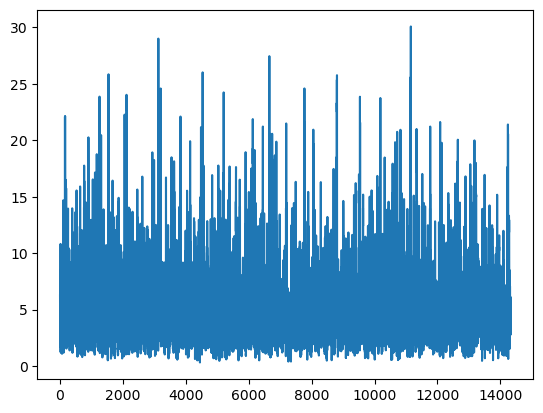

In [14]:
plot(Yprey)

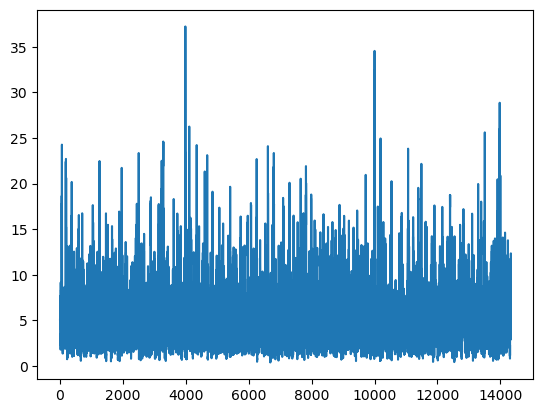

In [15]:
plot(Ypred)

In [16]:
SiPrey = sobol.analyze(problem, Yprey, print_to_console=True)

# Print the first-order sensitivity indices
#print(Si['S1'])

             ST   ST_conf
alpha  0.071103  0.010168
beta   0.226044  0.042562
delta  0.467605  0.073112
gamma  0.123417  0.041737
a      0.165717  0.030419
b      0.354704  0.077512
             S1   S1_conf
alpha  0.021629  0.028548
beta   0.093437  0.048132
delta  0.316179  0.093286
gamma  0.034973  0.030524
a      0.079809  0.042738
b      0.133825  0.054242
                      S2   S2_conf
(alpha, beta)   0.005221  0.048590
(alpha, delta)  0.013622  0.048630
(alpha, gamma)  0.002494  0.041836
(alpha, a)      0.003034  0.040643
(alpha, b)      0.027282  0.042067
(beta, delta)   0.018662  0.093237
(beta, gamma)  -0.007378  0.058510
(beta, a)      -0.013013  0.061714
(beta, b)       0.074885  0.073358
(delta, gamma)  0.021566  0.140655
(delta, a)      0.048631  0.141325
(delta, b)      0.012016  0.150353
(gamma, a)      0.025215  0.042077
(gamma, b)      0.010940  0.038116
(a, b)         -0.017187  0.056493


In [18]:
SiPred = sobol.analyze(problem, Ypred, print_to_console=True)

# Print the first-order sensitivity indices
#print(Si['S1'])

             ST   ST_conf
alpha  0.108692  0.031969
beta   0.458791  0.067482
delta  0.205455  0.040846
gamma  0.070734  0.014057
a      0.345359  0.062481
b      0.161093  0.024573
             S1   S1_conf
alpha  0.041453  0.031329
beta   0.336385  0.086959
delta  0.079241  0.049725
gamma  0.014892  0.025534
a      0.144788  0.048211
b      0.078517  0.034778
                      S2   S2_conf
(alpha, beta)  -0.004016  0.085032
(alpha, delta)  0.002699  0.055879
(alpha, gamma) -0.012151  0.048917
(alpha, a)     -0.010895  0.053246
(alpha, b)      0.011787  0.060501
(beta, delta)  -0.025484  0.142764
(beta, gamma)  -0.042115  0.149390
(beta, a)      -0.034749  0.144623
(beta, b)      -0.005599  0.145627
(delta, gamma)  0.001486  0.071863
(delta, a)      0.087456  0.080325
(delta, b)     -0.007009  0.066653
(gamma, a)      0.036512  0.048007
(gamma, b)      0.015017  0.050326
(a, b)          0.005751  0.069686


In [19]:
import math
import torch
import gpytorch

In [32]:
# Define the model inputs
problemTrain = {
    'num_vars': 6,
    'names': ['alpha', 'beta', 'delta', 'gamma','a','b'],
    'bounds': [[1, 5],
               [1, 5],
               [1, 5],
               [1, 5],
               [0.1,5],
               [0.1,5]]
}

# Generate samples
train = saltelli.sample(problem, 100)

YpreyTrain = np.zeros([train.shape[0]])
YpredTrain = np.zeros([train.shape[0]])
# Run model (example)
for i,p1 in enumerate(train):
    p=p1[0:4]
    w=[p1[4],p1[5]]
    preyMax,predMax= maxDensities(w,t,p,SolveP)
    YpreyTrain[i] = preyMax
    YpredTrain[i] = predMax

#idx = np.random.randint(param_values.shape[0], size=500)
#train = param_values[idx,:]

#YpreyTrain = Yprey[idx]
#YpredTrain = Ypred[idx]

C:\Users\chris\AppData\Local\Temp\ipykernel_33148\339174800.py:14: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  train = saltelli.sample(problem, 100)
C:\Users\chris\Anaconda3\lib\site-packages\SALib\sample\saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)


In [33]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
    
# initialize likelihood and model
likelihoodPred = gpytorch.likelihoods.GaussianLikelihood()
likelihoodPrey = gpytorch.likelihoods.GaussianLikelihood()
predModel = ExactGPModel(torch.tensor(train), torch.tensor(YpredTrain), likelihoodPred)
preyModel = ExactGPModel(torch.tensor(train), torch.tensor(YpreyTrain), likelihoodPrey)

In [91]:
torch.tensor(train).shape

torch.Size([1400, 6])

In [36]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
preyModel.train()
likelihoodPrey.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(preyModel.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihoodPrey, preyModel)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = preyModel(torch.tensor(train))
    # Calc loss and backprop gradients
    Y2=torch.tensor(YpredTrain)
    loss = -mll(output, Y2)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        preyModel.covar_module.base_kernel.lengthscale.item(),
        preyModel.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 6.394   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 5.332   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 4.469   lengthscale: 0.798   noise: 0.797
Iter 4/50 - Loss: 3.799   lengthscale: 0.853   noise: 0.848
Iter 5/50 - Loss: 3.290   lengthscale: 0.909   noise: 0.897
Iter 6/50 - Loss: 2.897   lengthscale: 0.965   noise: 0.944
Iter 7/50 - Loss: 2.600   lengthscale: 1.022   noise: 0.987
Iter 8/50 - Loss: 2.387   lengthscale: 1.077   noise: 1.025
Iter 9/50 - Loss: 2.223   lengthscale: 1.132   noise: 1.058
Iter 10/50 - Loss: 2.080   lengthscale: 1.185   noise: 1.086
Iter 11/50 - Loss: 1.982   lengthscale: 1.236   noise: 1.110
Iter 12/50 - Loss: 1.911   lengthscale: 1.286   noise: 1.128
Iter 13/50 - Loss: 1.837   lengthscale: 1.333   noise: 1.141
Iter 14/50 - Loss: 1.778   lengthscale: 1.379   noise: 1.150
Iter 15/50 - Loss: 1.736   lengthscale: 1.422   noise: 1.155
Iter 16/50 - Loss: 1.700   lengthscale: 1.463   noise: 1.155
Iter 17/50 - Loss: 1.671   length

TypeError: 'tuple' object is not callable

In [37]:
loss

tensor(1.0325, dtype=torch.float64, grad_fn=<NegBackward0>)

In [38]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
predModel.train()
likelihoodPred.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(predModel.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihoodPred, predModel)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = predModel(torch.tensor(train))
    # Calc loss and backprop gradients
    Y2=torch.tensor(YpredTrain)
    loss = -mll(output, Y2)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        predModel.covar_module.base_kernel.lengthscale.item(),
        predModel.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 6.396   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 5.327   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 4.469   lengthscale: 0.798   noise: 0.797
Iter 4/50 - Loss: 3.802   lengthscale: 0.853   noise: 0.848
Iter 5/50 - Loss: 3.293   lengthscale: 0.909   noise: 0.898
Iter 6/50 - Loss: 2.903   lengthscale: 0.965   noise: 0.944
Iter 7/50 - Loss: 2.607   lengthscale: 1.022   noise: 0.987
Iter 8/50 - Loss: 2.384   lengthscale: 1.077   noise: 1.025
Iter 9/50 - Loss: 2.218   lengthscale: 1.132   noise: 1.059
Iter 10/50 - Loss: 2.081   lengthscale: 1.185   noise: 1.087
Iter 11/50 - Loss: 1.974   lengthscale: 1.236   noise: 1.111
Iter 12/50 - Loss: 1.900   lengthscale: 1.286   noise: 1.129
Iter 13/50 - Loss: 1.846   lengthscale: 1.333   noise: 1.143
Iter 14/50 - Loss: 1.779   lengthscale: 1.379   noise: 1.152
Iter 15/50 - Loss: 1.738   lengthscale: 1.422   noise: 1.157
Iter 16/50 - Loss: 1.700   lengthscale: 1.463   noise: 1.157
Iter 17/50 - Loss: 1.667   length

In [39]:
output

MultivariateNormal(loc: torch.Size([1400]))

In [40]:
# Get into evaluation (predictive posterior) mode
predModel.eval()
likelihoodPred.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [41]:
# Get into evaluation (predictive posterior) mode
preyModel.eval()
likelihoodPrey.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [42]:
predatorPredict=predModel(torch.tensor([[0.4,1,1,1,1,1]]))
preyPredict=preyModel(torch.tensor([[0.4,1,1,1,1,1]]))

In [43]:
predatorPredict

MultivariateNormal(loc: tensor([1.7511], dtype=torch.float64, grad_fn=<ViewBackward0>))

In [44]:
preyPredict.mean

tensor([1.7942], dtype=torch.float64, grad_fn=<ViewBackward0>)

In [45]:
maxDensities(w=[1,1],t=10,p=[0.4,1,1,1],SolveP=SolveP)

(1.8470986273446572, 1.0)

In [46]:
torch.sort(torch.tensor(Ypred),descending=True)

torch.return_types.sort(
values=tensor([37.2342, 34.5554, 32.3949,  ...,  0.4417,  0.4216,  0.3778],
       dtype=torch.float64),
indices=tensor([ 3985, 10000,  9996,  ..., 11858, 12534,  6686]))

In [47]:
np.mean(Ypred)

4.917067498628709

In [48]:
YpreyGP = np.zeros([param_values.shape[0]])
YpredGP = np.zeros([param_values.shape[0]])
# Run model (example)
for i,p1 in enumerate(param_values):
    p1=np.array(p1)
    YpreyGP[i] = preyModel(torch.tensor([p1])).mean
    YpredGP[i] = predModel(torch.tensor([p1])).mean

C:\Users\chris\AppData\Local\Temp\ipykernel_33148\2798276118.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  YpreyGP[i] = preyModel(torch.tensor([p1])).mean


In [49]:
SiPredGP = sobol.analyze(problem, YpredGP, print_to_console=True)

# Print the first-order sensitivity indices
#print(Si['S1'])

             ST   ST_conf
alpha  0.100385  0.021502
beta   0.440273  0.070058
delta  0.214735  0.037062
gamma  0.078848  0.013824
a      0.358779  0.047131
b      0.135233  0.017413
             S1   S1_conf
alpha  0.049155  0.025082
beta   0.304919  0.065877
delta  0.079387  0.037998
gamma  0.016696  0.029171
a      0.164696  0.046262
b      0.079392  0.034867
                      S2   S2_conf
(alpha, beta)   0.002796  0.056252
(alpha, delta) -0.002142  0.041426
(alpha, gamma) -0.011802  0.039073
(alpha, a)     -0.015558  0.042248
(alpha, b)      0.001286  0.041188
(beta, delta)   0.009034  0.108749
(beta, gamma)  -0.008911  0.113774
(beta, a)       0.006424  0.118796
(beta, b)       0.006463  0.108486
(delta, gamma)  0.016277  0.060421
(delta, a)      0.109621  0.066863
(delta, b)      0.010853  0.056541
(gamma, a)      0.037733  0.053005
(gamma, b)      0.013840  0.051156
(a, b)          0.001250  0.064537


In [50]:
SipreyGP = sobol.analyze(problem, YpreyGP, print_to_console=True)

# Print the first-order sensitivity indices
#print(Si['S1'])

             ST   ST_conf
alpha  0.064654  0.009930
beta   0.236729  0.043468
delta  0.429410  0.060173
gamma  0.109792  0.025076
a      0.150446  0.019497
b      0.354083  0.048851
             S1   S1_conf
alpha  0.026936  0.021995
beta   0.115799  0.042685
delta  0.297098  0.078415
gamma  0.042627  0.026356
a      0.085324  0.036520
b      0.169266  0.049491
                      S2   S2_conf
(alpha, beta)   0.001687  0.033585
(alpha, delta)  0.007090  0.034385
(alpha, gamma)  0.002630  0.029411
(alpha, a)      0.002791  0.028240
(alpha, b)      0.012654  0.033436
(beta, delta)   0.022331  0.080569
(beta, gamma)  -0.017504  0.061326
(beta, a)      -0.016302  0.066815
(beta, b)       0.066585  0.070599
(delta, gamma)  0.022700  0.112260
(delta, a)      0.028017  0.114304
(delta, b)      0.029370  0.133114
(gamma, a)      0.019121  0.041953
(gamma, b)      0.004067  0.039531
(a, b)         -0.005404  0.047154


In [73]:
np.sqrt(np.mean(((YpreyGP-Yprey)**2)))

0.7348090471423322

In [69]:
np.std(Yprey)

3.005584357773415

In [74]:
np.sqrt(np.mean(((YpredGP-Ypred)**2)))

0.7998116096501299

In [71]:
np.std(Ypred)

3.019952575675407

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

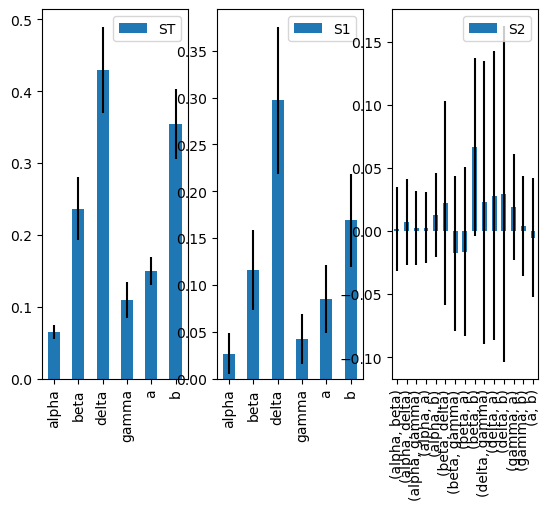

In [67]:
SipreyGP.plot()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

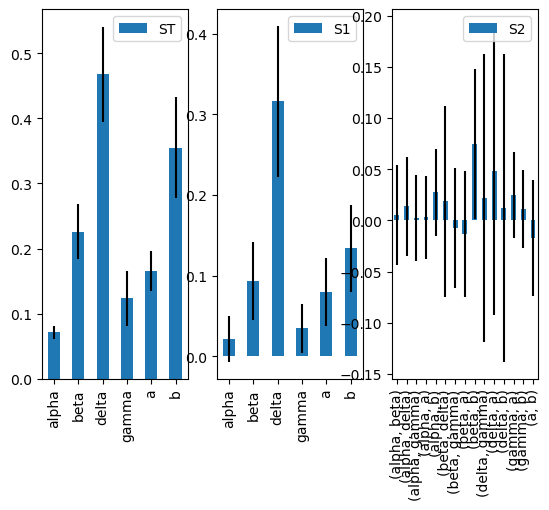

In [65]:
SiPrey.plot()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

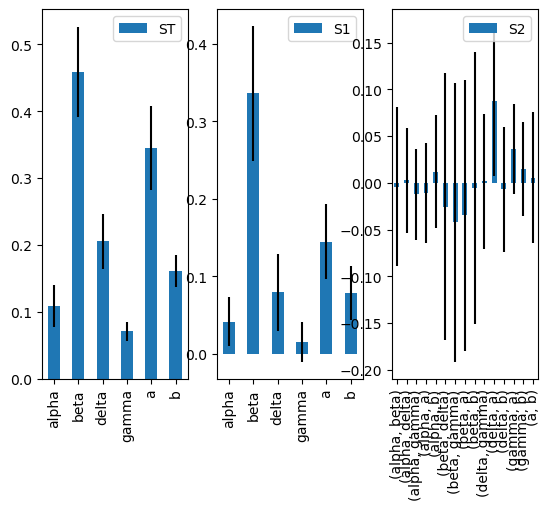

In [62]:
SiPred.plot()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

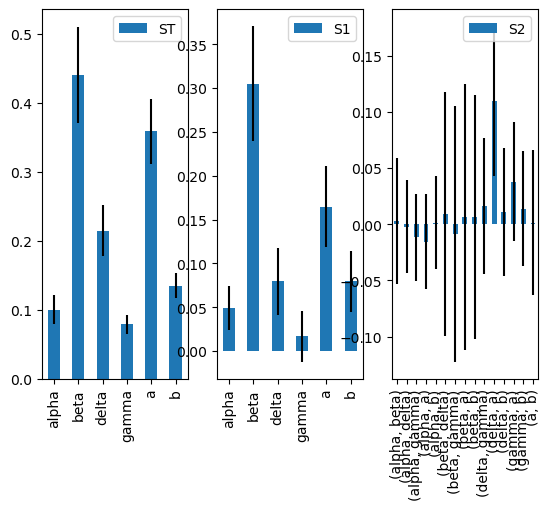

In [61]:
SiPredGP.plot()

(array([1.3637e+04, 4.7400e+02, 1.4400e+02, 4.3000e+01, 1.8000e+01,
        8.0000e+00, 8.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([5.43333125e-05, 1.29440015e+00, 2.58874597e+00, 3.88309179e+00,
        5.17743761e+00, 6.47178343e+00, 7.76612925e+00, 9.06047507e+00,
        1.03548209e+01, 1.16491667e+01, 1.29435125e+01]),
 <BarContainer object of 10 artists>)

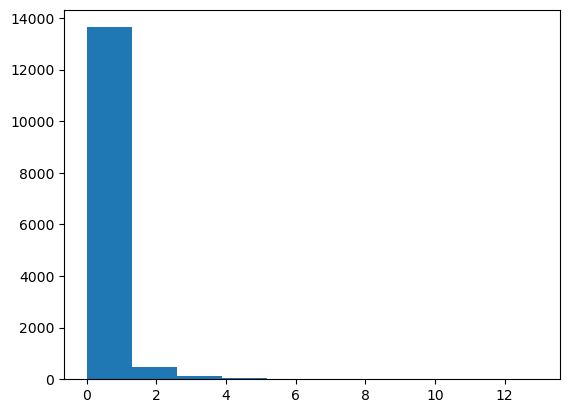

In [81]:
import matplotlib.pyplot as plt
plt.hist(np.abs(Yprey-YpreyGP))

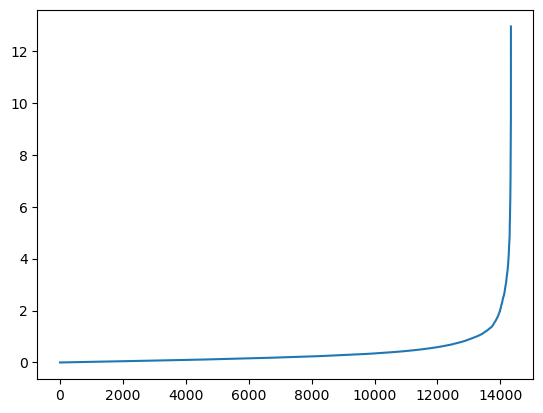

In [83]:
plt.plot(np.sort(np.abs(Yprey-YpreyGP)))